In [503]:
# TODO: Deal with the NaN values of each column

In [504]:
# Importing libraries
import torch
from torch import nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [505]:
# Install torchmetrics for accuracy
!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy
accuracy = BinaryAccuracy()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [506]:
# Setting up data agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [507]:
# Read in the training data
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [508]:
# Keep the PassengerID
test_passenger = test["PassengerId"]

In [509]:
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [510]:
# Checking for NaN values
data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [511]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [512]:
# Turn the transported into categorical for visualization
mapping = {True : "yes",False : "no"}
data['Transported'] = data['Transported'].map(mapping)

## Converting Categorical Data/Minor Pre-processing

In [513]:
def initial_data_processing(data: pd.DataFrame):
  """Initial Pre-processesing of the spaceship titanic data
  
  Args:
    data: pd.DataFrame -- The raw spaceship titanic data
    
  Returns:
    data: pd.DataFrame -- The processed spaceship titanic data"""

  # Drop Cabin and Passenger ID (Note: this is temporary)
  # data.drop(["Cabin"], axis = 1, inplace = True)
  data.drop(["Name"], axis = 1, inplace = True) # Drop name column
  data.drop(["PassengerId"], axis = 1, inplace = True)

  # Impute missing values of Age using the mean
  imp_mean = SimpleImputer(strategy = "mean")
  imp_frequent = SimpleImputer(strategy = "most_frequent")
  categorical_columns = data.select_dtypes(include = "object").columns
  numerical_columns = data.select_dtypes(include = "float64").columns
  data[numerical_columns] = imp_mean.fit_transform(data[numerical_columns])
  data[categorical_columns] = imp_frequent.fit_transform(data[categorical_columns])


  # Mapping Categorical Data (HomePlanet, Destination, CryoSleep, VIP)
  data["HomePlanet"] = pd.Categorical(data["HomePlanet"])
  data["Destination"] = pd.Categorical(data["Destination"])
  data['CryoSleep'] = data['CryoSleep'].map(mapping)
  data["CryoSleep"] = pd.Categorical(data["CryoSleep"])
  data["VIP"] = pd.Categorical(data["VIP"])
  

  

  # Combine all Amenities Spent into One Column
  # amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
  # data["AmenitiesCost"] = data[amenities].sum(axis = 1)

  # Move the new column and drop the old ones
  # data.drop(amenities, axis = 1, inplace = True)
  # amenities_col = data.pop("AmenitiesCost")
  # data.insert(len(data.columns)-1, "AmenitiesCost", amenities_col)

  # LabelEncode the categorical data
  encoder = LabelEncoder()
  for category in categorical_columns:
    data[category] = encoder.fit_transform(data[category])

  # Normalize the Age Column
  scaler = StandardScaler()
  data["Age"] = scaler.fit_transform(data[numerical_columns])

  

  return data

In [514]:
data = initial_data_processing(data)

In [515]:
data.isnull().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

### Data Visualization

In [516]:
categorical_data = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

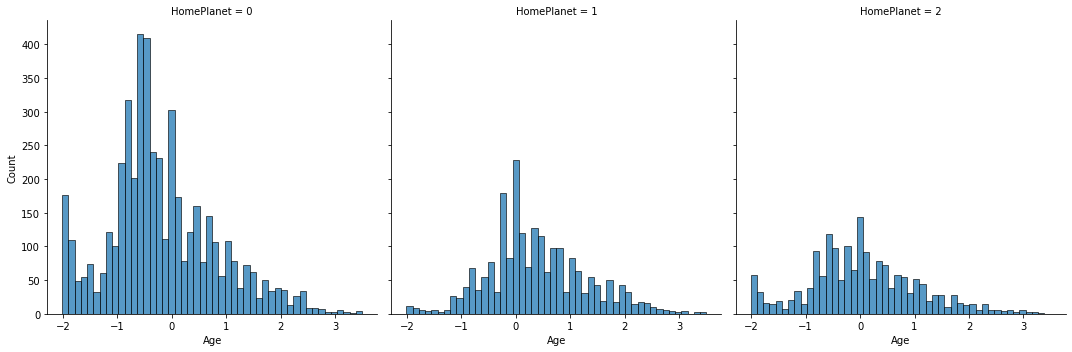

In [517]:
# Plotting Age conditioned on Home Planet
sns.displot(data=data, x="Age", col="HomePlanet")

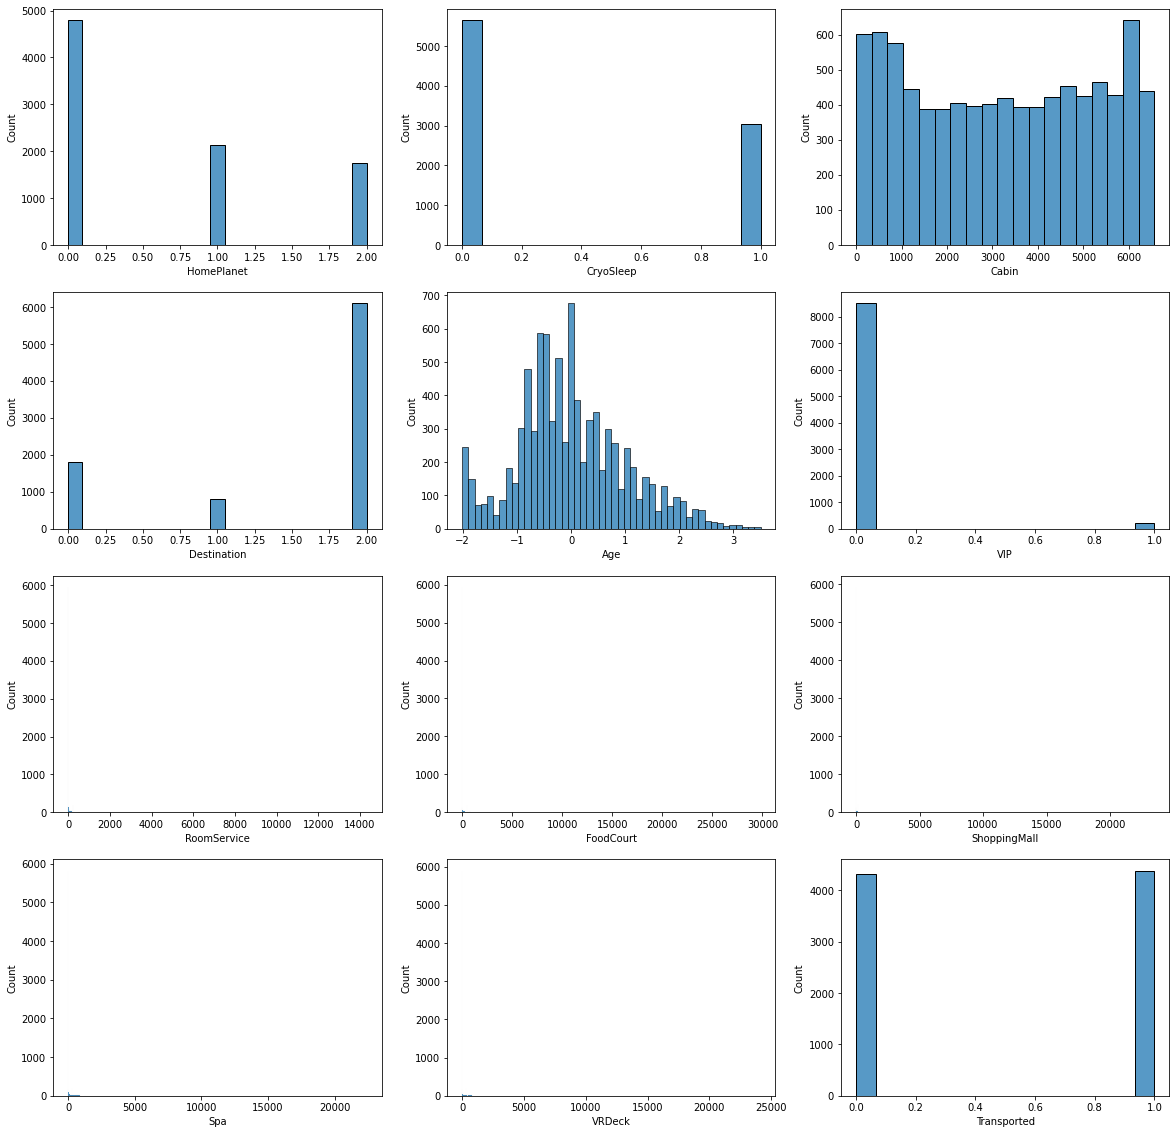

In [518]:
# Plotting histogram of all columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))  
for i, column in enumerate(data.columns):
    sns.histplot(data=data, x=column, ax=axes[i // 3, i % 3])

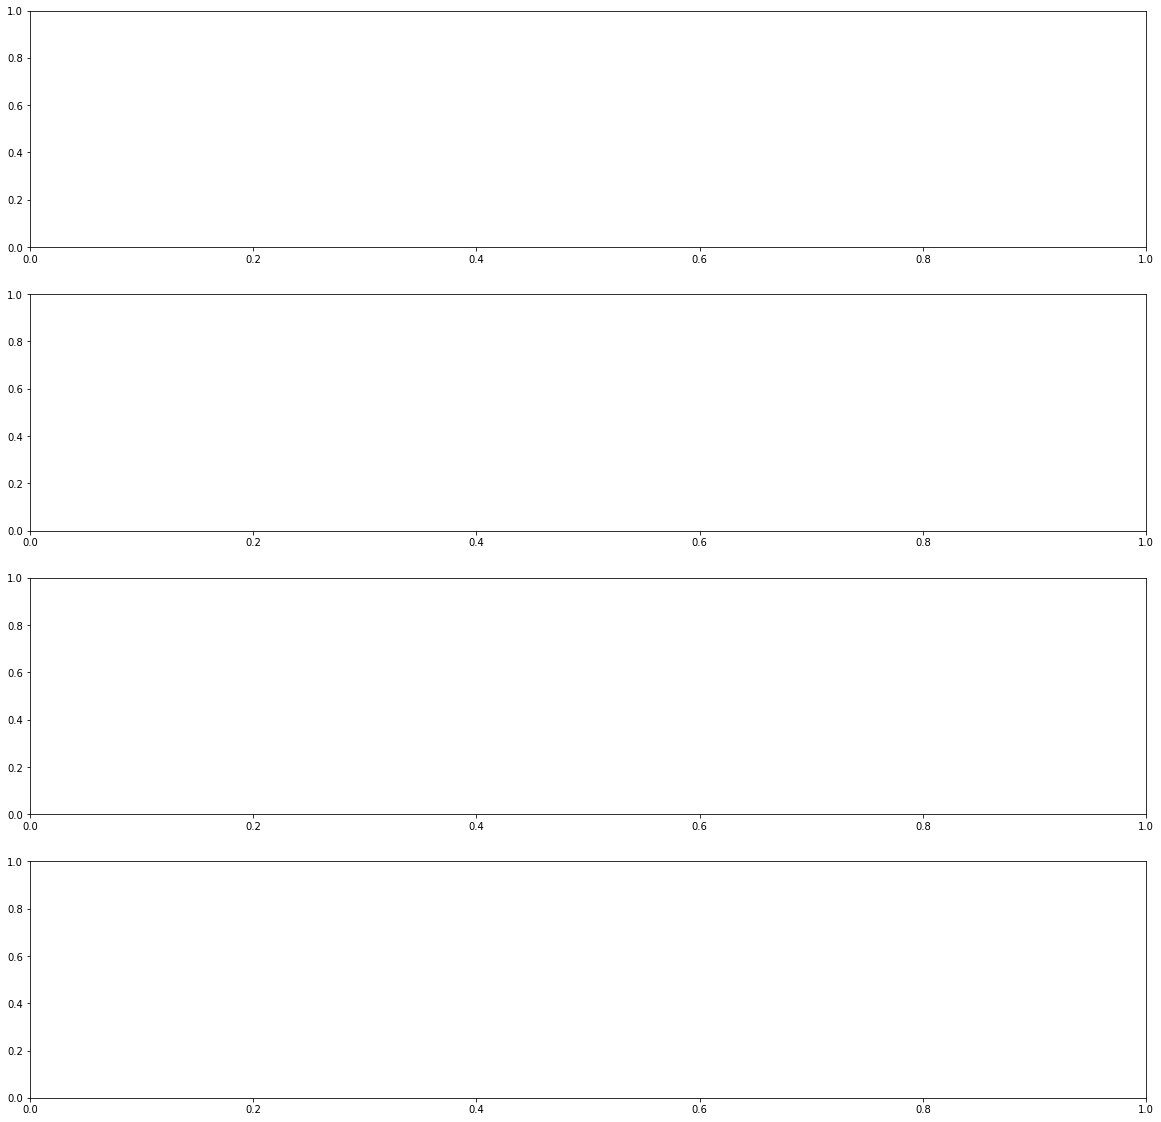

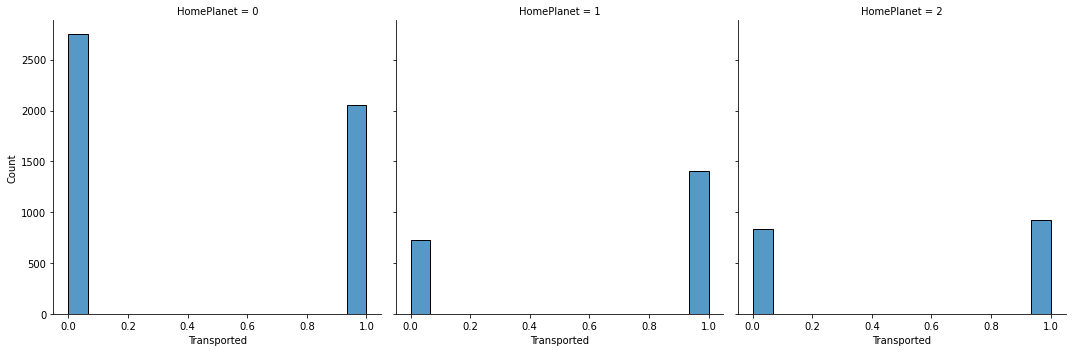

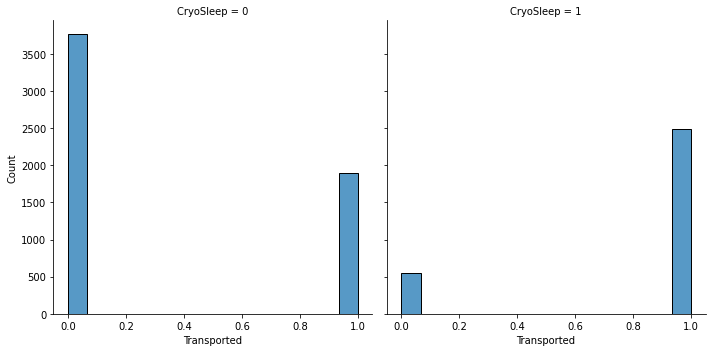

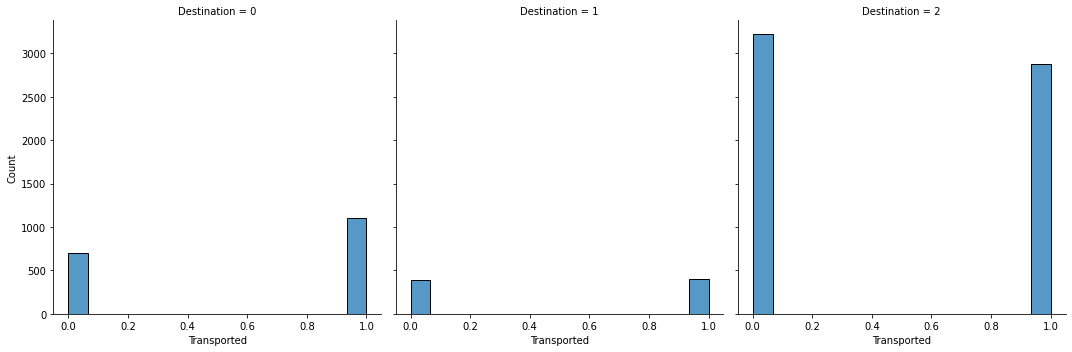

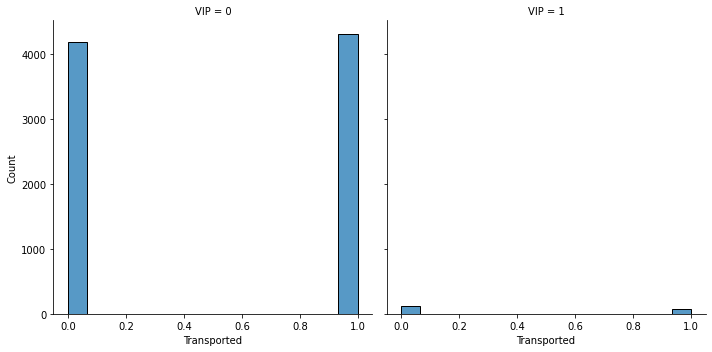

In [519]:
# Plotting joint/conditional distributions
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))  
for i, column in enumerate(categorical_data):
  sns.displot(data=data, x="Transported", col=column)

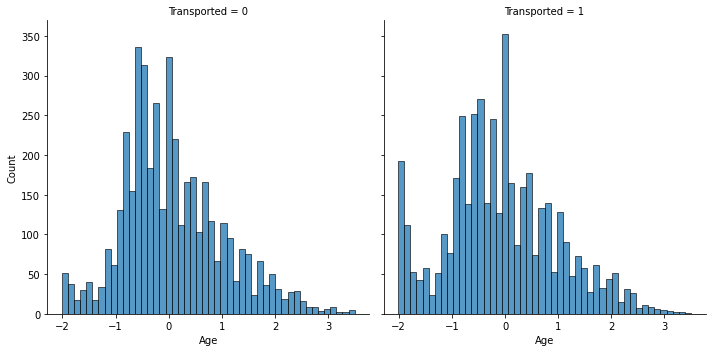

In [520]:
# Give transported or not what ages are we looking at
sns.displot(data, x= "Age", col="Transported")

### Training a Model

In [521]:
data

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,149,2,0.709437,0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,2184,2,-0.336717,0,109.0,9.0,25.0,549.0,44.0,1
2,1,0,1,2,2.034566,1,43.0,3576.0,0.0,6715.0,49.0,0
3,1,0,1,2,0.290975,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0,0,2186,2,-0.894666,0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,146,0,0.848924,1,0.0,6819.0,0.0,1643.0,74.0,0
8689,0,1,5280,1,-0.755179,0,0.0,0.0,0.0,0.0,0.0,0
8690,0,0,5285,2,-0.197230,0,0.0,0.0,1872.0,1.0,0.0,1
8691,1,0,2131,0,0.221232,0,0.0,1049.0,0.0,353.0,3235.0,0


In [522]:
# Separate feature and target columns
X = data[data.columns[:-1]].to_numpy()
y = data[data.columns[-1]].to_numpy()

In [523]:
# Convert data to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [524]:
# Split the training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state = 42)

In [525]:
# Create the model
class TransportModel(nn.Module):
  def __init__(self, input_features, hidden_units, output_features):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)

    )
  def forward(self, x: torch.tensor):
    return self.layer(x)

In [526]:
X.shape

torch.Size([8693, 11])

In [527]:
# Initializing the model
input_features = len(X[0,:])
hidden_units = 32
output_features = 1
model = TransportModel(input_features, hidden_units, output_features)

In [528]:
# Set up the loss function and optimizer

# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [529]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set up the parameters
epochs = 2000
epoch_number = []
loss_values = []
val_loss_values = []

for epoch in range(epochs):
  model.train()

  # Forward step
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Evaluate model
  model.eval()
  with torch.inference_mode():
    y_val_logits = model(X_val).squeeze()
    y_val_pred = torch.round(torch.sigmoid(y_val_logits))
    val_loss = loss_fn(y_val_logits, y_val)
    val_acc = accuracy(y_val_pred, y_val)

  if epoch % 100 == 0:
    epoch_number.append(epoch)
    loss_values.append(loss)
    val_loss_values.append(val_loss)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2}")

Epoch: 0 | Loss: 0.89158, Acc: 0.62 | Val Loss: 0.82431, Val Acc: 0.63
Epoch: 100 | Loss: 0.52875, Acc: 0.78 | Val Loss: 0.52690, Val Acc: 0.78
Epoch: 200 | Loss: 0.51271, Acc: 0.79 | Val Loss: 0.51741, Val Acc: 0.78
Epoch: 300 | Loss: 0.50595, Acc: 0.79 | Val Loss: 0.51589, Val Acc: 0.78
Epoch: 400 | Loss: 0.50068, Acc: 0.79 | Val Loss: 0.51334, Val Acc: 0.78
Epoch: 500 | Loss: 0.49586, Acc: 0.79 | Val Loss: 0.51142, Val Acc: 0.78
Epoch: 600 | Loss: 0.49121, Acc: 0.79 | Val Loss: 0.51015, Val Acc: 0.78
Epoch: 700 | Loss: 0.48669, Acc: 0.79 | Val Loss: 0.50941, Val Acc: 0.78
Epoch: 800 | Loss: 0.48206, Acc: 0.79 | Val Loss: 0.50839, Val Acc: 0.78
Epoch: 900 | Loss: 0.47332, Acc: 0.80 | Val Loss: 0.50117, Val Acc: 0.78
Epoch: 1000 | Loss: 0.46741, Acc: 0.80 | Val Loss: 0.49823, Val Acc: 0.78
Epoch: 1100 | Loss: 0.46063, Acc: 0.80 | Val Loss: 0.49559, Val Acc: 0.78
Epoch: 1200 | Loss: 0.45366, Acc: 0.80 | Val Loss: 0.49229, Val Acc: 0.78
Epoch: 1300 | Loss: 0.44747, Acc: 0.80 | Val Loss:

### Visualize the results

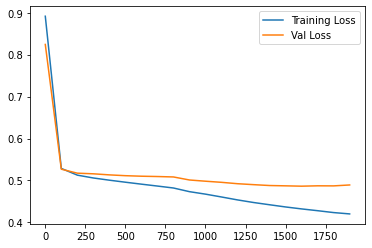

In [530]:
# Plot the training and test accuracies
plt.plot(epoch_number, torch.tensor(loss_values).numpy(), label = "Training Loss")
plt.plot(epoch_number, val_loss_values, label = "Val Loss")
plt.legend()

In [531]:
# Look at the test data
model.eval()
with torch.inference_mode():
  y_logits = model(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
test_loss = loss_fn(y_logits, y_test)
test_acc = accuracy(y_pred, y_test)
print(f"Test Loss: {test_loss:.5f} Test Acc: {test_acc:.2f}")

Test Loss: 0.51558 Test Acc: 0.77


In [532]:
# Process the test data
test_df = initial_data_processing(test)
test = torch.from_numpy(test_df.to_numpy()).type(torch.float)

In [533]:
test_df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,1,2784,2,-1.182216e-01,0,0.0,0.0,0.0,0.0,0.0
1,0,0,1867,2,-6.886014e-01,0,0.0,9.0,0.0,2823.0,0.0
2,1,1,257,0,1.669682e-01,0,0.0,0.0,0.0,0.0,0.0
3,1,0,259,2,6.660505e-01,0,0.0,6652.0,0.0,181.0,585.0
4,0,0,1940,2,-6.173039e-01,0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2679,2,3.808606e-01,0,0.0,0.0,0.0,0.0,0.0
4273,0,0,2691,2,9.512404e-01,0,0.0,847.0,17.0,10.0,144.0
4274,2,1,602,0,-2.532995e-16,0,0.0,0.0,0.0,0.0,0.0
4275,1,0,603,2,-2.532995e-16,0,0.0,2680.0,0.0,0.0,523.0


In [534]:
data.shape

(8693, 12)

In [535]:
# Make predictions on the real test data
model.eval()
with torch.inference_mode():
  test_logits = model(test).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

In [543]:
submission_df = pd.DataFrame({"PassengerId":test_passenger, "Transported":test_pred})
transport_mapping = {1.0: True, 0.0:False}
submission_df["Transported"] = submission_df["Transported"].map(transport_mapping)
submission_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [542]:
submission_df.to_csv("submission.csv", columns = ["PassengerId", "Transported"], index = False)